In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import jit
import numpy as np

import matplotlib.pyplot as plt
import gudhi as gd
# from gudhi.tensorflow import RipsLayer
from gudhi.representations import Landscape
#import tensorflow as tf
# import utils as u


In [2]:
@jit
def lorenz63(t, state, sigma=10.0, rho=28.0, beta=8.0/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def run_integration(T,rho,initial_state):

    t_span = (0.0, T)
    n=200*T
    t_eval = np.linspace(t_span[0], t_span[1], n)
    specific_system = lambda a,b: lorenz63(a,b,rho=rho)
    # Integrate the system
    solution = solve_ivp(specific_system, t_span, initial_state, t_eval=t_eval, vectorized=True)

    # Extract the results
    t = solution.t
    x, y, z = solution.y
    return t,x,y,z


In [3]:
def generate_pdm(random_initial_state, T=100, rho=[28],stride=100):
    #initialize return list
    result=np.empty((random_initial_state.shape[0], len(rho)), dtype=object)

    for i in range(random_initial_state.shape[0]):
        #get initial condition
        initial_state=random_initial_state[i,:]
        #integrate system for each rho
        for j in range(len(rho)):
            t,x,y,z=run_integration(T,rho[j],initial_state)
            #subsample 
            X = np.array([x,y,z]).T
            # Subsample the solution trajectory
            X= X[::stride]

            # Built the Rips Simplicial Complex
            rc = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)  # A RipsComplex where we introduce vertices, edges and triangles, but not higher dimensional simplices.
            # Compute and reads its persistence (in any dimension)
            rc.persistence()  # We compute its persistence diagram
            dgm = rc.persistence_intervals_in_dimension(1) 
            result[i, j]=dgm
    return result

In [4]:
#initiate random initial condition
mean=0
st_dev=1
random_initial_state = mean+st_dev * np.random.randn(1,3)

#generate list of varying parameter rho
rho=np.linspace(90,105,20)

PD_array=generate_pdm(random_initial_state, T=1000, rho=rho,stride=1000)

In [5]:
# Now compute the Wasserstein Distance between the first two diagrams:
norms = np.zeros(PD_array.shape[1])
for j in range(PD_array.shape[1]):
    l=Landscape(num_landscapes=2,resolution=10).fit_transform([PD_array[0, j]])

    norms[j]  = np.linalg.norm(l[0])
     
    #Wdist = gd.representations.metrics.WassersteinDistance(order=2.)
    #dist = Wdist.fit(PD_array[:,j])
    #dist_matrix = Wdist.transform(PD_array[:,j])
    #print( "rho:" , rho[j], "mean:", dist_matrix.mean(), "std:", dist_matrix.std())

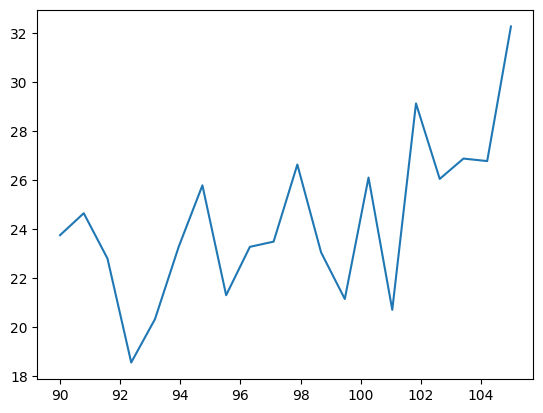

In [6]:
plt.plot(rho, norms)